In [1]:
! nvidia-smi

Tue Feb 28 16:13:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

In [2]:
! wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-02-28 16:18:06--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-02-28 16:18:06 (57.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import (create_tensorboard_callback,
                             plot_loss_curves,
                             unzip_data,
                             compare_historys,
                             walk_through_dir)

In [4]:
! wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2023-02-28 16:20:21--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.11.128, 172.253.123.128, 142.251.107.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.11.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  75.3MB/s    in 22s     

2023-02-28 16:20:43 (69.2 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
unzip_data("101_food_classes_10_percent.zip")

In [13]:
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [7]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/churros'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/french_onion_soup'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/eggs_benedict'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/nachos'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/bread_pudding'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/bibimbap'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/donuts'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/spring_rolls'.
There are 0 directories and 75 images in '1

In [8]:
import tensorflow as tf

In [9]:
IMG_SIZE = (224, 224)

In [17]:
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                               batch_size=32,
                                                                               label_mode="categorical",
                                                                               image_size=IMG_SIZE)
test_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                              batch_size=32,
                                                                              label_mode="categorical",
                                                                              image_size=IMG_SIZE,
                                                                              shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [18]:
checkpoints_path = "checkpoints/"
checkpointer = tf.keras.callbacks.ModelCheckpoint(checkpoints_path,
                                                 save_best_only=True,
                                                 monitor="val_accuracy",
                                                 save_weights_only=True)

In [19]:
data_augmentation_block = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
    tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
#     tf.keras.layers.experimental.preprocessing.Rescaling(1./255), # for models like resnet
], name="data_augmentation")

In [21]:
base = tf.keras.applications.EfficientNetB0(include_top=False)
base.trainable = False

In [29]:
inputs = tf.keras.layers.Input(shape=(224,224,3), name="inputs")
x = data_augmentation_block(inputs)
x = base(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(101, activation="softmax", name="outputs")(x)
model = tf.keras.models.Model(inputs, outputs)
model.compile(loss="categorical_crossentropy",
             optimizer="adam",
             metrics=["accuracy"])

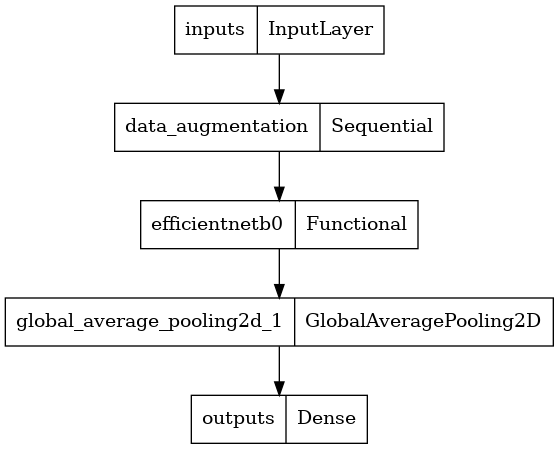

In [30]:
tf.keras.utils.plot_model(model)

In [31]:
history = model.fit(train_data_all_10_percent, epochs=5, validation_data=test_data_all_10_percent)

Epoch 1/5
237/237 [==============================] - 134s 528ms/step - loss: 3.3797 - accuracy: 0.2772 - val_loss: 2.3009 - val_accuracy: 0.4874
Epoch 2/5
237/237 [==============================] - 125s 525ms/step - loss: 2.2008 - accuracy: 0.4947 - val_loss: 1.8656 - val_accuracy: 0.5464
Epoch 3/5
237/237 [==============================] - 124s 523ms/step - loss: 1.8174 - accuracy: 0.5694 - val_loss: 1.7025 - val_accuracy: 0.5670
Epoch 4/5
237/237 [==============================] - 121s 511ms/step - loss: 1.6194 - accuracy: 0.6074 - val_loss: 1.6178 - val_accuracy: 0.5808
Epoch 5/5
237/237 [==============================] - 122s 512ms/step - loss: 1.4579 - accuracy: 0.6428 - val_loss: 1.5707 - val_accuracy: 0.5871
